# Growth factor model

In [1]:
import os

import arviz as az
import chi
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import pints
import seaborn as sns
import xarray as xr
sns.set_theme()

The data-generating model is a hierarchical tumour necrosis factor model
(Chaves et al., 2008) governed by

$$
    p(y, \psi | \theta , t) = p(y | \psi , t)\, p(\psi | \theta),
$$

where $\psi$ are the bottom-level parameters and
$\theta$ are the top-level parameters.
The measurements of individuals are governed by a distribution defined by the
mechanistic model-error model pair

$$
    p(y | \psi , t) =
        \mathrm{LN}\left( y | \log \bar{y}(\psi, t), \sigma \right)
$$

with $\bar{y} = c_a$ models the concentration of activated cell receptors which
is described by

$$
    \frac{\mathrm{d}c_8}{\mathrm{d}t} =
        -k^{\mathrm{off}}_{8} c_8 + k^{\mathrm{on}}_{8, \mathrm{tnf}} \frac{d^2_{8, \mathrm{nf}}}{c_{\mathrm{nf}}^2 + d^2_{8, \mathrm{nf}}} \frac{c^2_{\mathrm{tnf}}}{c_{\mathrm{tnf}}^2 + a^2_{8, \mathrm{tnf}}} + k^{\mathrm{on}}_{8, 3}  \frac{c^2_{3}}{c_{3}^2 + a^2_{8, 3}}\\
    \frac{\mathrm{d}c_3}{\mathrm{d}t} =
        -k^{\mathrm{off}}_{3} c_3 + k^{\mathrm{on}}_{3} \frac{d^2_{3, \mathrm{nf}}}{c_{\mathrm{nf}}^2 + d^2_{3, \mathrm{nf}}} \frac{c^2_{8}}{c_{8}^2 + a^2_{3, 8}}\\
    \frac{\mathrm{d}c_{\mathrm{nf}}}{\mathrm{d}t} =
        -k^{\mathrm{off}}_{\mathrm{nf}} c_{\mathrm{nf}} + k^{\mathrm{on}}_{\mathrm{nf}} \frac{d^2_{\mathrm{nf}, 3}}{c_{3}^2 + d^2_{\mathrm{nf}, 3}} \frac{d^2_{\mathrm{nf}, \mathrm{inf}}}{c_{\mathrm{inf}}^2 + d^2_{\mathrm{nf}, \mathrm{inf}}}\\
    \frac{\mathrm{d}c_{\mathrm{inf}}}{\mathrm{d}t} =
        -k^{\mathrm{off}}_{\mathrm{inf}} c_{\mathrm{inf}} + k^{\mathrm{on}}_{\mathrm{inf}, \mathrm{tnf}} \frac{d^2_{\mathrm{inf}, \mathrm{tnf}}}{c_{\mathrm{tnf}}^2 + d^2_{\mathrm{inf}, \mathrm{tnf}}} + k^{\mathrm{on}}_{\mathrm{inf}, \mathrm{nf}} \frac{c_{\mathrm{nf}}^2}{c_{\mathrm{nf}}^2 + a^2_{\mathrm{inf}, \mathrm{nf}}}\\
    \frac{\mathrm{d}a_{\mathrm{tnf}}}{\mathrm{d}t} = -k_e a_{\mathrm{tnf}} + r(t)\quad \mathrm{and} \quad c_{\mathrm{tnf}} = \frac{a_{\mathrm{tnf}}}{v}
$$
with initial conditions $c_8(t=0) = c_3(t=0) = 0$, $c_{\mathrm{nf}}(t=0) = 0.26$, and $c_{\mathrm{tnf}}(t=0) = 0.625$. Analogously to Hasenauer et al., we fix $k^{\mathrm{off}}_{8} = k^{\mathrm{off}}_{3} = k^{\mathrm{off}}_{\mathrm{nf}} = k^{\mathrm{off}}_{\mathrm{inf}} = k^{\mathrm{on}}_{3} = k^{\mathrm{on}}_{\mathrm{nf}} = 1$ and $k^{\mathrm{on}}_{8, \mathrm{tnf}} = k^{\mathrm{on}}_{8, 3} = k^{\mathrm{on}}_{\mathrm{inf}, \mathrm{tnf}} = k^{\mathrm{on}}_{\mathrm{inf}, \mathrm{nf}} = 0.5$.

Similar to Hasenauer et al., we administer TNF during $t\in [0, 2]$. Hasenauer et al. set TNF to a constant level of $c_{\mathrm{tnf}}=1$ during this interval, and set the TNF concentration to zero otherwise. To recreate this concentration profile, we fix $a_{\mathrm{tnf}}(t=0) = 1$, $v=1$, $k_e = 100$ and infuse TNF at a constant rate of $r_0 = 100$ from $t=0$ to $t=2$.

The inter-individual variability is governed by the population model

$$
    p(\psi | \theta) =
        \mathcal{N}(p | \mu_{p}, \sigma ^2_{p})\,
        \mathcal{N}(k_{\mathrm{on}} | \mu_{k_{\mathrm{on}}}, \sigma ^2_{k_{\mathrm{on}}})\,
        \delta (k_{\mathrm{off}} - \theta_{k_{\mathrm{off}}})\,
        \delta (k_{\mathrm{deg}, r} - \theta_{k_{\mathrm{deg}, r}})\,
        \delta (k_{\mathrm{deg}, a} - \theta_{k_{\mathrm{deg}, a}})\,
        \delta (\sigma - \theta_{\sigma}).
$$

## Define data-generating model

In [236]:
directory = os.path.dirname(os.getcwd())
mechanistic_model = chi.PKPDModel(
    directory + '/models/chaves_tnf_network_model.xml')
mechanistic_model.set_administration(
    compartment='central', amount_var='tumour_necrosis_factor_amount')
mechanistic_model.set_dosing_regimen(dose=2 * 100, duration=2, start=0)
mechanistic_model.set_outputs(['myokit.caspase_3'])
mechanistic_model = chi.ReducedMechanisticModel(mechanistic_model)
mechanistic_model.fix_parameters({
    'central.tumour_necrosis_factor_amount': 1,
    'myokit.caspase_3': 0,
    'myokit.caspase_8': 0,
    'myokit.nf_kappaB': 0.26,
    'myokit.nf_kappaB_inhibitor': 0.625,
    'central.size': 1,
    'myokit.activation_rate_c3': 1,
    'myokit.activation_rate_c8_c3': 0.5,
    'myokit.activation_rate_c8_tnf': 0.5,
    'myokit.activation_rate_inf_nf': 0.5,
    'myokit.activation_rate_inf_tnf': 0.5,
    'myokit.activation_rate_nf': 1,
    'myokit.deactivation_rate_c3': 1,
    'myokit.deactivation_rate_c8': 1,
    'myokit.deactivation_rate_inf': 1,
    'myokit.deactivation_rate_nf': 1,
    'myokit.elimination_rate': 100,
    'myokit.half_maximal_effect_concentration_c3_c8': 0.2,
    'myokit.half_maximal_effect_concentration_c8_c3': 0.2,
    'myokit.half_maximal_effect_concentration_c8_tnf': 0.6,
    'myokit.half_maximal_inhibitory_concentration_c8_nf': 0.5,
    'myokit.half_maximal_inhibitory_concentration_inf_tnf': 0.4,
    'myokit.half_maximal_inhibitory_concentration_nf_c3': 0.7,
    'myokit.half_maximal_inhibitory_concentration_nf_inf': 0.4
})

# Data-generating parameters
population_parameters = np.array([
    # 0.2,   # EC50 C3 C8
    # 0.2,   # EC50 C8 C3
    # 0.6,   # EC50 C8 TNF
    0.2,  # Mean EC50 C3 NF kappa B (non-apoptotic cells)
    0.005, # Std. EC50 C3 NF kappa B
    0.05,   # Mean shift EC50 C3 NF kappa B (apoptotic cells)
    # 0.5,   # EC50 C8 NF kappa B
    0.5,   # Mean EC50 NF inhibitor NF kappa B
    0.1,   # Std. EC50 NF inhibitor NF kappa B
    # 0.4,   # EC50 NF inhibitor TNF
    # 0.7,   # EC50 NF kappa B C3
    # 0.4,   # EC50 NF kappa B NF inhibitor
    0.05]) # Sigma

## 0. Distributional shape of data-generating process over time

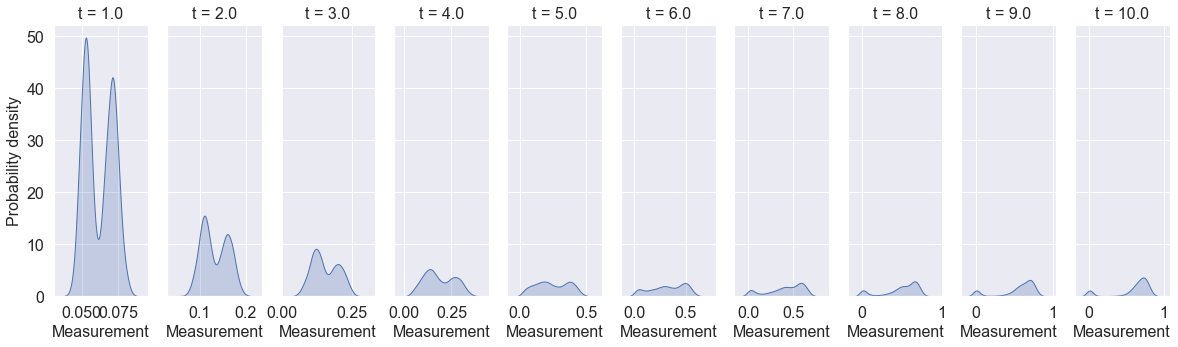

In [237]:
# Define data-generating model
error_model = chi.LogNormalErrorModel()
population_model = chi.ComposedPopulationModel([
    # chi.PooledModel(
    #     n_dim=3, dim_names=['EC50 C3 C8', 'EC50 C8 C3', 'EC50 C8 TNF']),
    chi.GaussianModel(dim_names=['EC50 C3 NF kappa B']),
    # chi.PooledModel(dim_names=['EC50 C8 NF kappa B']),
    chi.GaussianModel(dim_names=['EC50 NF inhibitor NF kappa B']),
    chi.PooledModel(n_dim=1, dim_names=[
        # 'EC50 NF inhibitor TNF',
        # 'EC50 NF kappa B C3',
        # 'EC50 NF kappa B NF inhibitor',
        'Sigma'])
])
predictive_model = chi.PredictiveModel(mechanistic_model, error_model)
predictive_model = chi.PopulationPredictiveModel(
    predictive_model, population_model)

# Simulate measurements
seed = 2
n_ids = 5000
times = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
measurements = np.empty((1, len(times), n_ids))
# mask = np.array([0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12])
mask = np.array([0, 1, 3, 4, 5])
parameters = population_parameters[mask]
measurements[:, :, :n_ids//2] = predictive_model.sample(
    parameters, times, n_samples=n_ids//2, seed=seed,
    return_df=False)
parameters[0] += population_parameters[2]
measurements[:, :, n_ids//2:] = predictive_model.sample(
    parameters, times, n_samples=n_ids//2, seed=seed,
    return_df=False)

# Visualise distributions over time
fontsize = '16'
fig, axes = plt.subplots(1, len(times), figsize=(20, 5), sharey='row')
axes[0].set_ylabel('Probability density', fontsize=fontsize)
for tid, time in enumerate(times):
    # Add title and x-label to subfigure
    axes[tid].set_title('t = %.1f' % time, fontsize=fontsize)
    axes[tid].set_xlabel('Measurement', fontsize=fontsize)
    axes[tid].tick_params(labelsize=fontsize)

    # Plot KDE plot
    sns.kdeplot(
        x=measurements[0, tid], fill=True, linewidth=1, ax=axes[tid],
        legend=False)

plt.show()

## 1. 100 Individuals (non-snapshot data)

In [238]:
# Simulate measurements
seed = 2
n_ids = 100
times = np.linspace(0.1, 10)
measurements = np.empty((1, len(times), n_ids))
mask = np.array([0, 1, 3, 4, 5])
parameters = population_parameters[mask]
measurements[:, :, :n_ids//2] = predictive_model.sample(
    parameters, times, n_samples=n_ids//2, seed=seed,
    return_df=False)
parameters[0] += population_parameters[2]
measurements[:, :, n_ids//2:] = predictive_model.sample(
    parameters, times, n_samples=n_ids//2, seed=seed,
    return_df=False)

# Swap axes for later convenience
measurements = np.moveaxis(
    measurements, source=(0, 1, 2), destination=(1, 2, 0))

fig = go.Figure()
for idx in range(n_ids):
    fig.add_trace(go.Scatter(
        x=times,
        y=measurements[idx, 0],
        mode='markers+lines',
        name='ID %d' % idx
    ))
fig.update_layout(
    template='plotly_white',
    xaxis_title='Time',
    yaxis_title='Measurement'
)
fig.show()

## 1. 5000 Individuals (snapshot data)

In [239]:
# Simulate measurements
seed = 2
n_ids = 5000
times = [1, 3.5, 7, 10.5, 14]
dense_measurements = np.empty((1, len(times), n_ids))
mask = np.array([0, 1, 3, 4, 5])
parameters = population_parameters[mask]
dense_measurements[:, :, :n_ids//2] = predictive_model.sample(
    parameters, times, n_samples=n_ids//2, seed=seed,
    return_df=False)
parameters[0] += population_parameters[2]
dense_measurements[:, :, n_ids//2:] = predictive_model.sample(
    parameters, times, n_samples=n_ids//2, seed=seed,
    return_df=False)

# Keep only one measurement per individual
order = np.arange(n_ids)
rng = np.random.default_rng(seed+1)
rng.shuffle(order)
dense_measurements = dense_measurements[:, :, order]
n_ids = 1000
n_times = len(times)
n_observables = 1
measurements = np.empty(shape=(n_ids, n_observables, n_times))
for idt in range(n_times):
    start_ids = idt * n_ids
    end_ids = (idt + 1) * n_ids
    measurements[:, 0, idt] = dense_measurements[0, idt, start_ids:end_ids]

# Visualise measurements
fig = go.Figure()
for idt in range(n_times):
    for idx in range(n_ids):
        fig.add_trace(go.Scatter(
            x=[times[idt]],
            y=[measurements[idx, 0, idt]],
            mode='markers+lines',
            name='ID %d' % (idt + (n_times * idx))
        ))
fig.update_layout(
    template='plotly_white',
    xaxis_title='Time',
    yaxis_title='Measurement'
)
fig.show()

### Population filter inference

#### 1. Maximum entropy approach for multi-modal parameter

In [260]:
times

[1, 3.5, 7, 10.5, 14]

/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.9/site-packages/arviz/plots/traceplot.py:212: UserWarning:

rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (108), generating only 20 plots



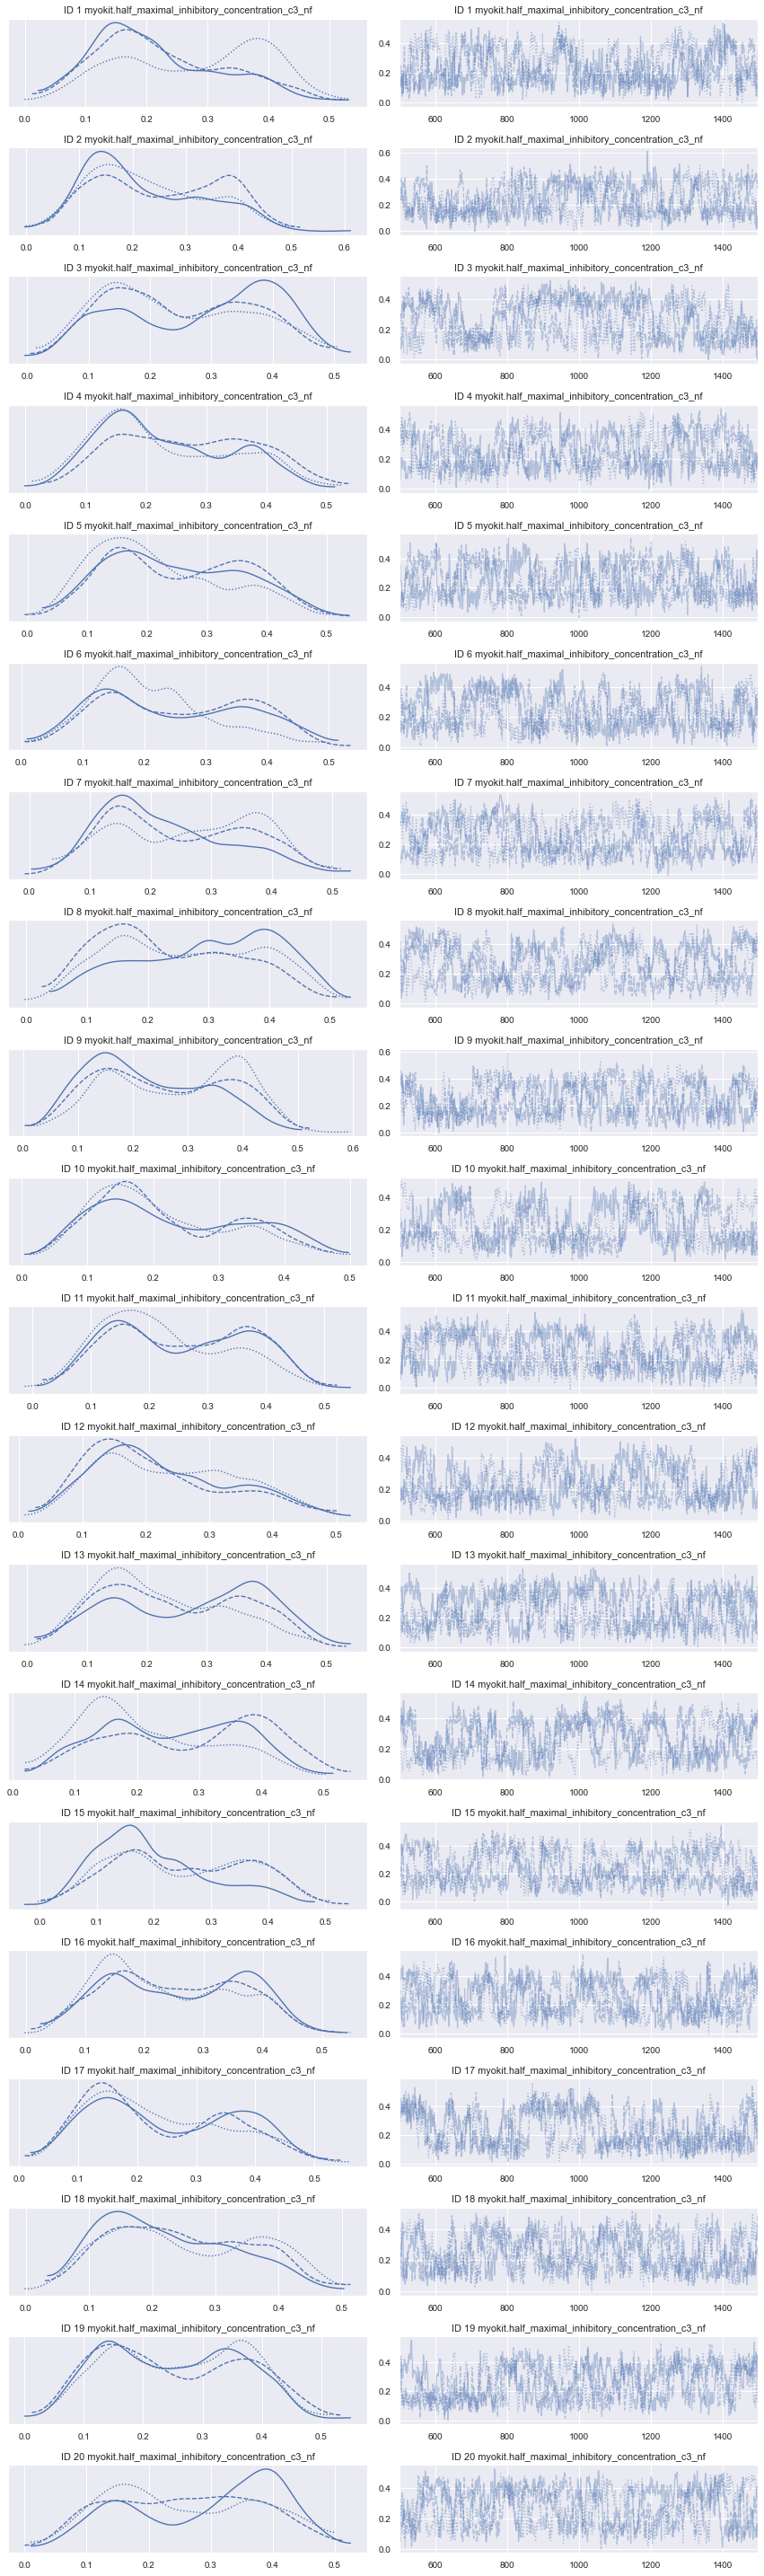

In [268]:
# Define population filter log-posterior
n_samples = 100
population_filter = chi.GaussianFilter(measurements)
# population_model = chi.ComposedPopulationModel([
#     chi.PooledModel(
#         n_dim=3, dim_names=['EC50 C3 C8', 'EC50 C8 C3', 'EC50 C8 TNF']),
#     chi.HeterogeneousModel(dim_names=['EC50 C3 NF kappa B']),
#     chi.PooledModel(dim_names=['EC50 C8 NF kappa B']),
#     chi.GaussianModel(
#         dim_names=['EC50 NF inhibitor NF kappa B'], centered=False),
#     chi.PooledModel(n_dim=3, dim_names=[
#         'EC50 NF inhibitor TNF',
#         'EC50 NF kappa B C3',
#         'EC50 NF kappa B NF inhibitor'])
# ])
population_model =  chi.ComposedPopulationModel([
    chi.HeterogeneousModel(dim_names=['EC50 C3 NF kappa B']),
    chi.GaussianModel(
        dim_names=['EC50 NF inhibitor NF kappa B'], centered=False)])
log_prior = pints.ComposedLogPrior(*[
    # pints.LogNormalLogPrior(-1.5, 0.5),     # EC50 C3 C8
    # pints.LogNormalLogPrior(-1.5, 0.5),     # EC50 C8 C3
    # pints.LogNormalLogPrior(-0.5, 0.3)]     # EC50 C8 TNF
    # + [
        pints.GaussianLogPrior(0.22, 0.05)  # EC50 C3 NF kappa B
    ] * n_samples + [
    # pints.LogNormalLogPrior(-0.5, 0.3),     # EC50 C8 NF kappa B
    pints.GaussianLogPrior(0.6, 0.1),       # Mean EC50 NF inhibitor NF kappa B
    pints.LogNormalLogPrior(-2, 0.2),       # Std. EC50 NF inhibitor NF kappa B
    # pints.LogNormalLogPrior(-0.5, 0.3),     # EC50 NF inhibitor TNF
    # pints.LogNormalLogPrior(-0.5, 0.3),     # EC50 NF kappa B C3
    # pints.LogNormalLogPrior(-0.5, 0.3),     # EC50 NF kappa B NF inhibitor
])
log_posterior = chi.PopulationFilterLogPosterior(
    population_filter, times, mechanistic_model, population_model, log_prior,
    sigma=population_parameters[-1], n_samples=n_samples)

# Load inference results
directory = os.getcwd()
posterior_samples = xr.load_dataset(
    directory
    + '/derived_data/posteriors/tnf_network_model_maximum_entropy_gf.nc')

# Plot traces
warmup = 500
thinning = 1
n_iterations = 1500
az.plot_trace(
    posterior_samples.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

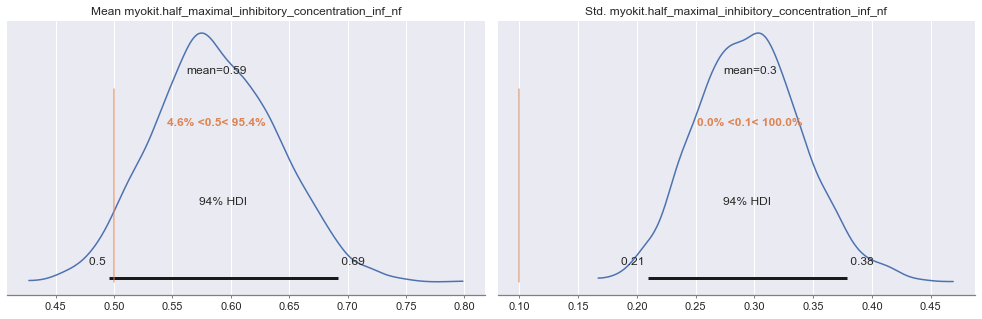

In [272]:
warmup = 500
thinning = 1
az.plot_posterior(
    posterior_samples.sel(draw=slice(warmup, n_iterations, thinning)),
    var_names=[
        'Mean myokit.half_maximal_inhibitory_concentration_inf_nf',
        'Std. myokit.half_maximal_inhibitory_concentration_inf_nf'],
    ref_val=list(population_parameters[3:5]))
plt.tight_layout()

In [281]:
xr.concat([
    posterior_samples['ID 1 myokit.half_maximal_inhibitory_concentration_c3_nf'],
    posterior_samples['ID 2 myokit.half_maximal_inhibitory_concentration_c3_nf']], dim='chain')

<xarray.DataArray 'ID 1 myokit.half_maximal_inhibitory_concentration_c3_nf' (
                                                                             chain: 6,
                                                                             draw: 1500)>
array([[0.20238198, 0.20238198, 0.20238198, ..., 0.04131911, 0.10456894,
        0.11938251],
       [0.21909049, 0.21909049, 0.21909049, ..., 0.3065372 , 0.31828537,
        0.36155029],
       [0.08641491, 0.08641491, 0.08641491, ..., 0.19094943, 0.1790787 ,
        0.1928247 ],
       [0.32854043, 0.32854043, 0.32854043, ..., 0.09189221, 0.11733901,
        0.11703812],
       [0.10429478, 0.10429478, 0.10429478, ..., 0.05665064, 0.02828686,
        0.09012023],
       [0.16799384, 0.16799384, 0.16799384, ..., 0.34488571, 0.32782783,
        0.39612701]])
Coordinates:
  * chain    (chain) int64 0 1 2 0 1 2
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1493 1494 1495 1496 1497 1498 1499

In [277]:
list(posterior_samples.keys())

['ID 1 myokit.half_maximal_inhibitory_concentration_c3_nf',
 'ID 2 myokit.half_maximal_inhibitory_concentration_c3_nf',
 'ID 3 myokit.half_maximal_inhibitory_concentration_c3_nf',
 'ID 4 myokit.half_maximal_inhibitory_concentration_c3_nf',
 'ID 5 myokit.half_maximal_inhibitory_concentration_c3_nf',
 'ID 6 myokit.half_maximal_inhibitory_concentration_c3_nf',
 'ID 7 myokit.half_maximal_inhibitory_concentration_c3_nf',
 'ID 8 myokit.half_maximal_inhibitory_concentration_c3_nf',
 'ID 9 myokit.half_maximal_inhibitory_concentration_c3_nf',
 'ID 10 myokit.half_maximal_inhibitory_concentration_c3_nf',
 'ID 11 myokit.half_maximal_inhibitory_concentration_c3_nf',
 'ID 12 myokit.half_maximal_inhibitory_concentration_c3_nf',
 'ID 13 myokit.half_maximal_inhibitory_concentration_c3_nf',
 'ID 14 myokit.half_maximal_inhibitory_concentration_c3_nf',
 'ID 15 myokit.half_maximal_inhibitory_concentration_c3_nf',
 'ID 16 myokit.half_maximal_inhibitory_concentration_c3_nf',
 'ID 17 myokit.half_maximal_inhib

### Results

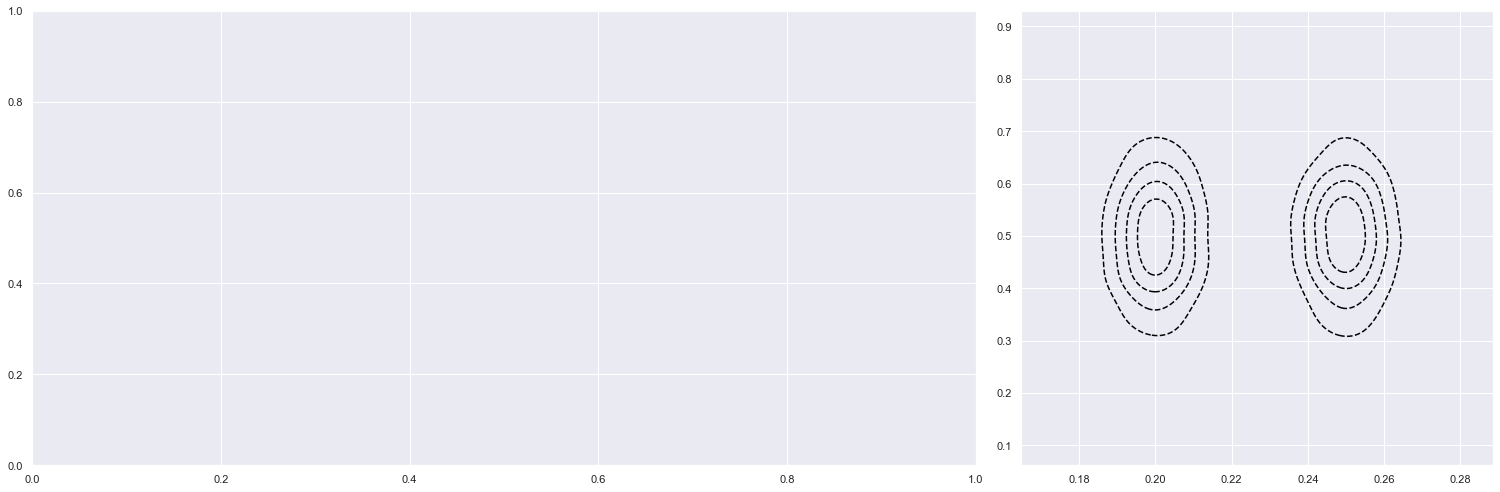

In [205]:
# Set up figure
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(21, 7), gridspec_kw={'width_ratios': [2, 1]})

# Define population model (central parametrisation)
population_model = chi.ComposedPopulationModel([
    chi.PooledModel(
        n_dim=3, dim_names=['EC50 C3 C8', 'EC50 C8 C3', 'EC50 C8 TNF']),
    chi.GaussianModel(dim_names=['EC50 C3 NF kappa B']),
    chi.PooledModel(dim_names=['EC50 C8 NF kappa B']),
    chi.GaussianModel(dim_names=['EC50 NF inhibitor NF kappa B']),
    chi.PooledModel(n_dim=4, dim_names=[
        'EC50 NF inhibitor TNF',
        'EC50 NF kappa B C3',
        'EC50 NF kappa B NF inhibitor',
        'Sigma'])
])

# Plot population filter inference results (parameter space)
seed = np.random.default_rng(3)
n_samples = 5000
parameters =  posterior_samples.sel(draw=slice(warmup, n_iterations))
parameters = np.vstack([
    parameters['Mean myokit.activation_rate'].values.flatten(),
    parameters['Std. myokit.activation_rate'].values.flatten(),
    # parameters['Log std. Initial count'].values.flatten(),
    # parameters['Log std. Growth rate'].values.flatten(),
    parameters['Mean myokit.production_rate'].values.flatten(),
    parameters['Std. myokit.production_rate'].values.flatten()]).T
parameters = parameters[
    np.random.choice(np.arange(len(parameters)), size=n_samples, replace=True)]
samples = np.empty(shape=(n_samples, 2))
for ids, params in enumerate(parameters):
    samples[ids, :] = population_model.sample(params, seed=seed)[0]
sns.kdeplot(
    x=samples[:, 0], y=samples[:, 1], fill=True, bw_adjust=1.5,
    levels=[0.2, 0.4, 0.6, 0.8, 1], ax=axes[1])

# # Plot population filter inference results (measurement space)
# times = np.linspace(0.1, 15)
# n_times = len(times)
# predictive_model = chi.PredictiveModel(mechanistic_model, error_model)
# simulated_measurements = np.empty(shape=(n_samples, n_times))
# parameters = np.empty(shape=(n_samples, 3))
# parameters[:, :2] = samples
# parameters[:, 2] = population_parameters[-1]
# for ids, sample in enumerate(parameters):
#     simulated_measurements[ids, :] = predictive_model.sample(
#         parameters=sample, times=times, seed=seed, return_df=False)[0, :, 0]
# fifth_percentile = np.percentile(simulated_measurements, q=5, axis=0)
# ninetyfifth_percentile = np.percentile(simulated_measurements, q=95, axis=0)
# axes[0].plot(
#     times, fifth_percentile, color=plt.get_cmap('Blues_r')(0))
# axes[0].plot(
#     times, ninetyfifth_percentile, color=plt.get_cmap('Blues_r')(0))
# axes[0].fill_between(
#     times, fifth_percentile, ninetyfifth_percentile,
#     color=plt.get_cmap('Blues_r')(0), alpha=0.5)

# Plot data-generating distribution as reference to parameter space
samples = np.empty(shape=(n_samples, 10))
mask = np.array([0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12])
parameters = population_parameters[mask]
samples[:n_samples//2] = population_model.sample(
    parameters, n_samples//2, seed)
parameters[3] += population_parameters[5]
samples[n_samples//2:] = population_model.sample(
    parameters, n_samples//2, seed)
sns.kdeplot(
    x=samples[:, 3], y=samples[:, 5], fill=False, color='black',
    levels=[0.2, 0.4, 0.6, 0.8, 1], linestyles='dashed', ax=axes[1])

# # Plot measurement used for the inference as reference
# times = np.array([5, 10, 15])
# for idm, meas in enumerate(measurements):
#     axes[0].scatter(
#         times, meas[0], color='black', marker='o', alpha=0.3)

# Legend, ranges axes labels
# fontsize = 16
# axes[0].set_xlabel('Time', fontsize=fontsize)
# axes[0].set_ylabel('Count', fontsize=fontsize)
# axes[0].tick_params(labelsize=fontsize)
# axes[0].plot(
#     [100, 101], [100, 101], color='black', linestyle='solid', marker='o',
#     label='Measurements')
# axes[0].plot(
#     [100, 101], [100, 101], color=plt.get_cmap('Blues_r')(0),
#     linestyle='solid', label='Posterior 5th-95th perc.')
# axes[0].set_xlim([-0.25, 15.25])
# axes[0].set_ylim([-0.25, 3.5])
# axes[1].plot(
#     [100, 101], [100, 101], color='black', linestyle='--', label='True')
# axes[1].plot(
#     [100, 101], [100, 101], color=plt.get_cmap('Blues_r')(0),label='Inferred')
# axes[1].set_xlim([1.45, 2])
# axes[1].set_ylim([1.475, 1.9])
# axes[1].set_xlabel('Activation rate', fontsize=fontsize)
# axes[1].set_ylabel('Production rate', fontsize=fontsize)
# axes[1].tick_params(labelsize=fontsize)
# axes[0].legend(fontsize=fontsize)
# axes[1].legend(fontsize=fontsize)
plt.tight_layout()

## 2. Snapshot data from both active and inactive receptors

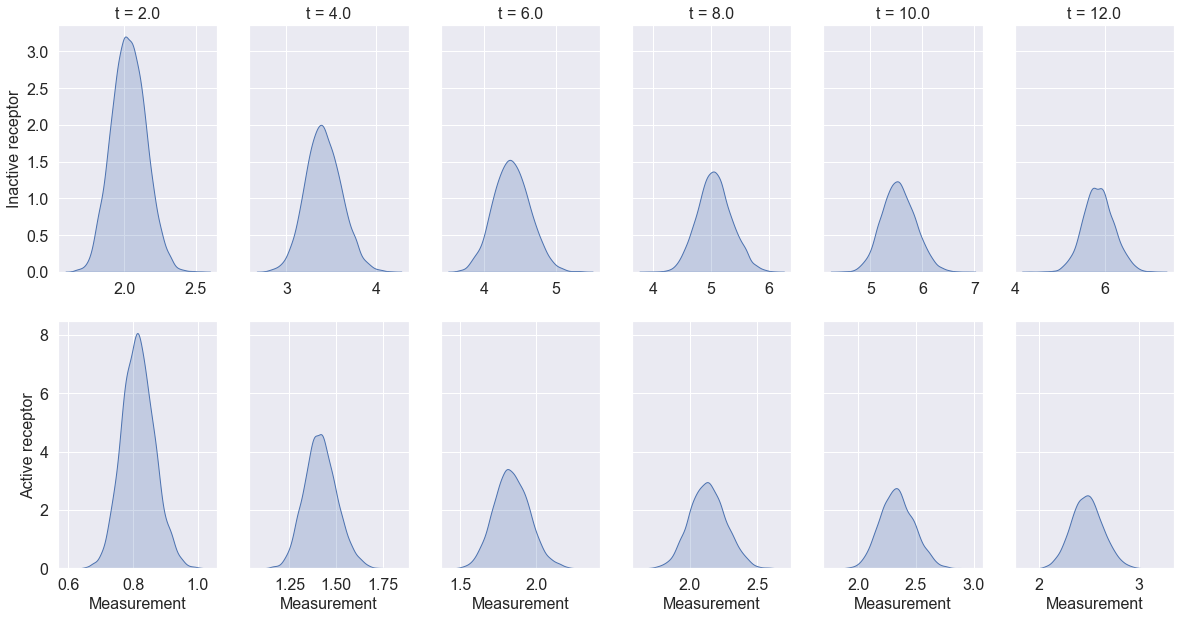

In [20]:
# Data-generating parameters
population_parameters = [
    1.7,   # Mean activation rate
    0.05,  # Std. activation rate
    8,     # deactivation rate
    0.015, # degradation rate (active)
    0.25,  # degradation rate (inactive)
    1.7,   # Mean production rate
    0.05,  # Std. production rate
    0.05,  # Sigma act.
    0.05]  # Sigma inact.

# Define mechanistic model
directory = os.path.dirname(os.getcwd())
mechanistic_model = chi.SBMLModel(
    directory + '/models/dixit_growth_factor_model.xml')
mechanistic_model = chi.ReducedMechanisticModel(mechanistic_model)
mechanistic_model.fix_parameters({
    'central.receptor_active_amount': 0,
    'central.receptor_inactive_amount': 0,
    'central.ligand_amount': 2,
    'central.size': 1
})

# Define data-generating model
error_models = [chi.LogNormalErrorModel(), chi.LogNormalErrorModel()]
population_model = chi.ComposedPopulationModel([
    chi.GaussianModel(dim_names=['Activation rate']),
    chi.PooledModel(n_dim=3, dim_names=[
        'Deactivation rate', 'Deg. rate (act.)', 'Deg. rate (inact.)']),
    chi.GaussianModel(dim_names=['Production rate']),
    chi.PooledModel(dim_names=['Sigma act.']),
    chi.PooledModel(dim_names=['Sigma inact.'])])
predictive_model = chi.PredictiveModel(mechanistic_model, error_models)
predictive_model = chi.PopulationPredictiveModel(
    predictive_model, population_model)

# Simulate measurements
seed = 2
n_ids = 5000
times = [2, 4, 6, 8, 10, 12]
measurements = predictive_model.sample(
    population_parameters, times, n_samples=n_ids, seed=seed, return_df=False)

# Visualise distributions over time
fontsize = '16'
fig, axes = plt.subplots(2, len(times), figsize=(20, 10), sharey='row')
axes[0, 0].set_ylabel('Inactive receptor', fontsize=fontsize)
axes[1, 0].set_ylabel('Active receptor', fontsize=fontsize)
for tid, time in enumerate(times):
    # Add title and x-label to subfigure
    axes[0, tid].set_title('t = %.1f' % time, fontsize=fontsize)
    axes[1, tid].set_xlabel('Measurement', fontsize=fontsize)
    axes[0, tid].tick_params(labelsize=fontsize)
    axes[1, tid].tick_params(labelsize=fontsize)

    # Plot KDE plot
    sns.kdeplot(
        x=measurements[0, tid], fill=True, linewidth=1, ax=axes[1, tid],
        legend=False)
    sns.kdeplot(
        x=measurements[1, tid], fill=True, linewidth=1, ax=axes[0, tid],
        legend=False)

plt.show()

In [23]:
# Simulate measurements
seed = 2
n_ids = 5000
times = np.array([1, 5, 10, 15, 20])
dense_measurements = predictive_model.sample(
    population_parameters, times, n_samples=n_ids, seed=seed, return_df=False)

# Keep only one measurement per individual (100 measurements per time point)
n_ids = 1000
n_times = len(times)
n_observables = 2
measurements = np.empty(shape=(n_ids, n_observables, n_times))
for idt in range(n_times):
    start_ids = idt * n_ids
    end_ids = (idt + 1) * n_ids
    measurements[:, 0, idt] = dense_measurements[0, idt, start_ids:end_ids]
    measurements[:, 1, idt] = dense_measurements[1, idt, start_ids:end_ids]

# Visualise measurements
fig = go.Figure()
for idt in range(n_times):
    for idx in range(n_ids):
        fig.add_trace(go.Scatter(
            x=[times[idt]],
            y=[measurements[idx, 0, idt]],
            mode='markers+lines',
            name='ID %d' % (idt + (n_times * idx))
        ))
fig.update_layout(
    template='plotly_white',
    xaxis_title='Time',
    yaxis_title='Measurement'
)
fig.show()
fig = go.Figure()
for idt in range(n_times):
    for idx in range(n_ids):
        fig.add_trace(go.Scatter(
            x=[times[idt]],
            y=[measurements[idx, 1, idt]],
            mode='markers+lines',
            name='ID %d' % (idt + (n_times * idx))
        ))
fig.update_layout(
    template='plotly_white',
    xaxis_title='Time',
    yaxis_title='Measurement'
)
fig.show()

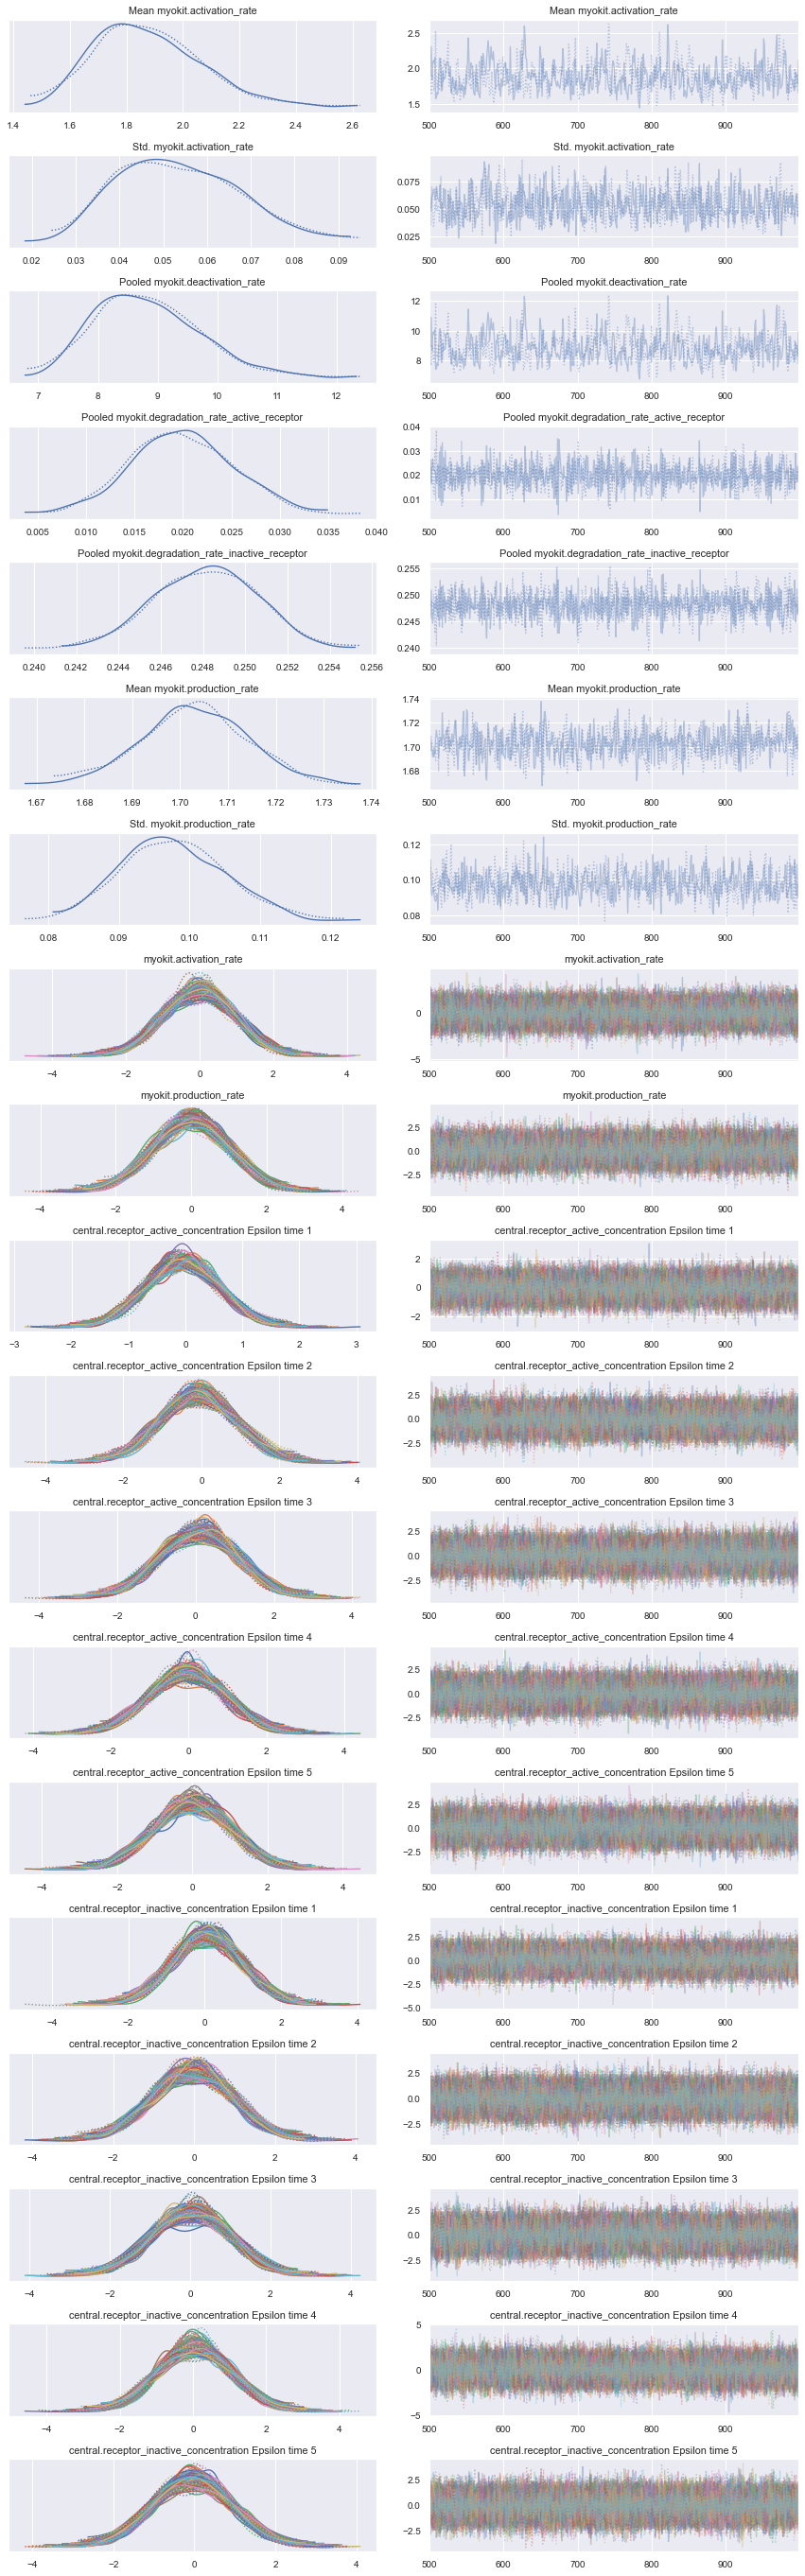

In [24]:
# Define population filter log-posterior
population_filter = chi.GaussianFilter(measurements)
population_model = chi.ComposedPopulationModel([
    chi.GaussianModel(dim_names=['Activation rate'], centered=False),
    chi.PooledModel(n_dim=3, dim_names=[
        'Deactivation rate', 'Deg. rate (act.)', 'Deg. rate (inact.)']),
    chi.GaussianModel(dim_names=['Production rate'], centered=False)])
log_prior = pints.ComposedLogPrior(
    pints.GaussianLogPrior(2, 0.5),      # Mean activation rate
    pints.LogNormalLogPrior(-2, 0.5),    # Std. activation rate
    pints.GaussianLogPrior(10, 2),       # deactivation rate
    pints.GaussianLogPrior(0.02, 0.005), # degradation rate (active)
    pints.GaussianLogPrior(0.3, 0.05),   # degradation rate (inactive)
    pints.GaussianLogPrior(2, 0.5),      # Mean production rate
    pints.LogNormalLogPrior(-2, 0.5))    # Std. production rate
log_posterior = chi.PopulationFilterLogPosterior(
    population_filter, times, mechanistic_model, population_model, log_prior,
    sigma=population_parameters[-2:])

# Load inference results
directory = os.getcwd()
chain_1 = xr.load_dataset(
    directory
    + '/derived_data/posteriors/growth_factor_model_2_outputs_chain_1.nc')
chain_2 = xr.load_dataset(
    directory
    + '/derived_data/posteriors/growth_factor_model_2_outputs_chain_2.nc')
posterior_samples = xr.concat(
    [chain_1, chain_2.assign_coords(chain=[1])], dim='chain')

# Plot traces
warmup = 500
thinning = 1
n_iterations = 1000
az.plot_trace(
    posterior_samples.sel(draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

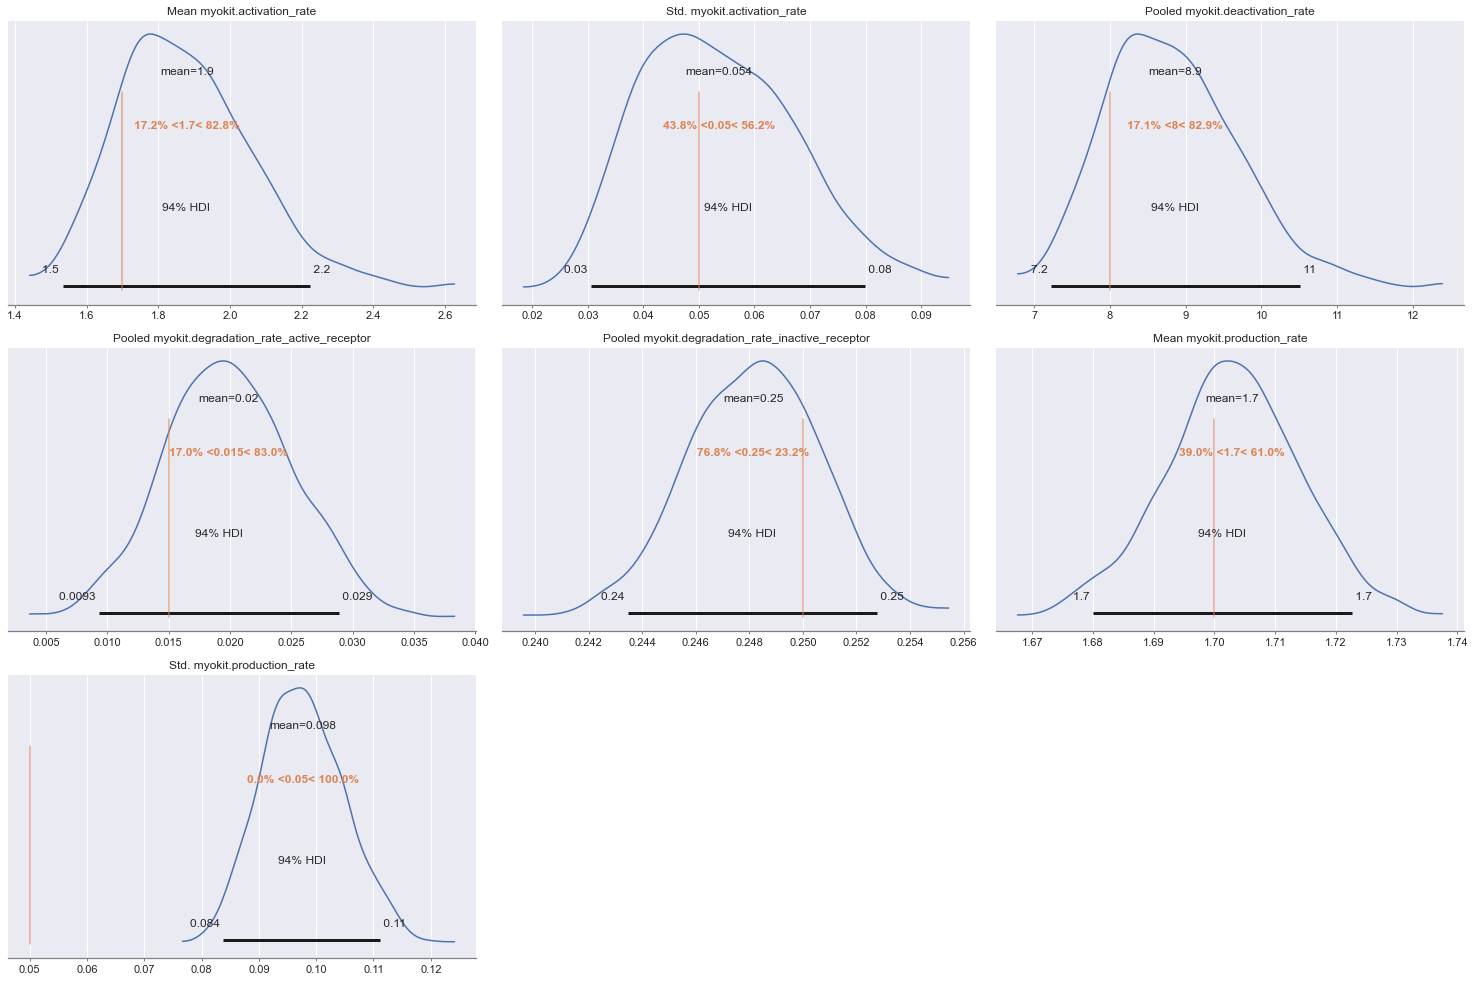

In [25]:
warmup = 500
thinning = 1
az.plot_posterior(
    posterior_samples.sel(draw=slice(warmup, n_iterations, thinning)),
    var_names=[
        'Mean myokit.activation_rate',
        'Std. myokit.activation_rate',
        'Pooled myokit.deactivation_rate',
        'Pooled myokit.degradation_rate_active_receptor',
        'Pooled myokit.degradation_rate_inactive_receptor',
        'Mean myokit.production_rate',
        'Std. myokit.production_rate'],
    ref_val=population_parameters[:-2])
plt.tight_layout()

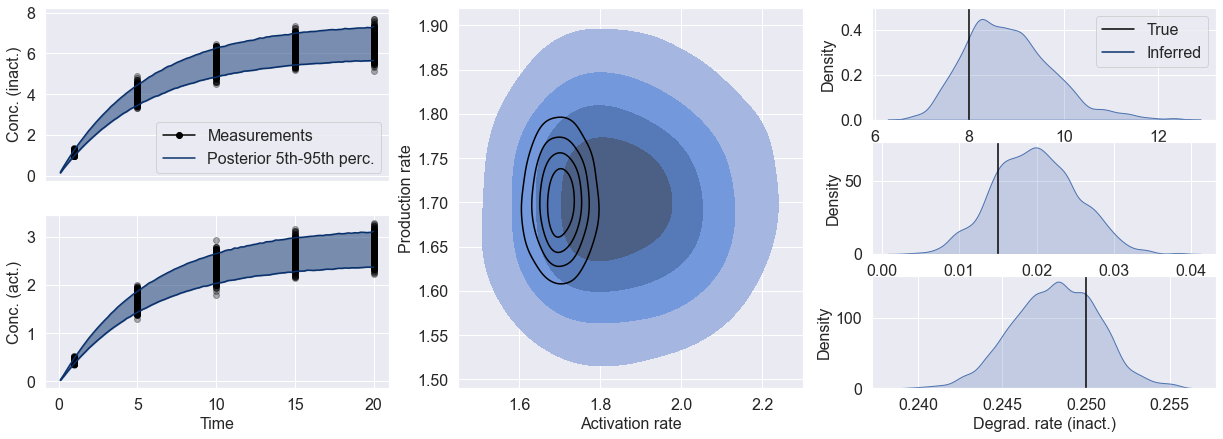

In [28]:
# Set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = plt.subplot(231)
ax2 = plt.subplot(234)
time_series_axes = [ax1, ax2]
param_axes = [
    fig.add_subplot(1, 3, 2),
    fig.add_subplot(3, 3, 3),
    fig.add_subplot(3, 3, 6),
    fig.add_subplot(3, 3, 9)]

# Define population model (central parametrisation)
population_model = chi.ComposedPopulationModel([
    chi.GaussianModel(dim_names=['Activation rate']),
    chi.PooledModel(n_dim=3, dim_names=[
        'Deactivation rate', 'Deg. rate (act.)', 'Deg. rate (inact.)']),
    chi.GaussianModel(dim_names=['Production rate'])])

# Plot population filter inference results (parameter space)
seed = np.random.default_rng(3)
n_samples = 5000
parameters =  posterior_samples.sel(draw=slice(warmup, n_iterations))
parameters = np.vstack([
    parameters['Mean myokit.activation_rate'].values.flatten(),
    parameters['Std. myokit.activation_rate'].values.flatten(),
    parameters['Pooled myokit.deactivation_rate'].values.flatten(),
    parameters[
        'Pooled myokit.degradation_rate_active_receptor'].values.flatten(),
    parameters[
        'Pooled myokit.degradation_rate_inactive_receptor'].values.flatten(),
    parameters['Mean myokit.production_rate'].values.flatten(),
    parameters['Std. myokit.production_rate'].values.flatten()]).T
parameters = parameters[
    np.random.choice(np.arange(len(parameters)), size=n_samples, replace=True)]
samples = np.empty(shape=(n_samples, 5))
for ids, params in enumerate(parameters):
    samples[ids, :] = population_model.sample(params, seed=seed)[0]
sns.kdeplot(
    x=samples[:, 0], y=samples[:, 4], fill=True, bw_adjust=1.5,
    levels=[0.2, 0.4, 0.6, 0.8, 1], ax=param_axes[0])
sns.kdeplot(
    x=samples[:, 1], fill=True, ax=param_axes[1])
sns.kdeplot(
    x=samples[:, 2], fill=True, ax=param_axes[2])
sns.kdeplot(
    x=samples[:, 3], fill=True, ax=param_axes[3])

# Plot population filter inference results (measurement space)
times = np.linspace(0.1, 20, 100)
n_times = len(times)
predictive_model = chi.PredictiveModel(mechanistic_model, error_models)
simulated_measurements = np.empty(shape=(n_samples, 2, n_times))
parameters = np.empty(shape=(n_samples, 7))
parameters[:, :5] = samples
parameters[:, 5] = population_parameters[-2]
parameters[:, 6] = population_parameters[-1]
for ids, sample in enumerate(parameters):
    simulated_measurements[ids, :] = predictive_model.sample(
        parameters=sample, times=times, seed=seed, return_df=False)[..., 0]
fifth_percentile = np.percentile(simulated_measurements, q=5, axis=0)
ninetyfifth_percentile = np.percentile(simulated_measurements, q=95, axis=0)
time_series_axes[0].plot(
    times, fifth_percentile[1], color=plt.get_cmap('Blues_r')(0))
time_series_axes[0].plot(
    times, ninetyfifth_percentile[1], color=plt.get_cmap('Blues_r')(0))
time_series_axes[0].fill_between(
    times, fifth_percentile[1], ninetyfifth_percentile[1],
    color=plt.get_cmap('Blues_r')(1), alpha=0.5)
time_series_axes[1].plot(
    times, fifth_percentile[0], color=plt.get_cmap('Blues_r')(0))
time_series_axes[1].plot(
    times, ninetyfifth_percentile[0], color=plt.get_cmap('Blues_r')(0))
time_series_axes[1].fill_between(
    times, fifth_percentile[0], ninetyfifth_percentile[0],
    color=plt.get_cmap('Blues_r')(0), alpha=0.5)

# Plot data-generating distribution as reference to parameter space
samples = population_model.sample(
    population_parameters[:-2], n_samples, seed)
sns.kdeplot(
    x=samples[:, 0], y=samples[:, 4], fill=False, bw_adjust=1.5, color='black',
    levels=[0.2, 0.4, 0.6, 0.8, 1], ax=param_axes[0])
param_axes[1].axvline(x=population_parameters[2], color='black')
param_axes[2].axvline(x=population_parameters[3], color='black')
param_axes[3].axvline(x=population_parameters[4], color='black')

# Plot measurement used for the inference as reference
times = np.array([1, 5, 10, 15, 20])
for idm, meas in enumerate(measurements):
    time_series_axes[1].scatter(
        times, meas[0], color='black', marker='o', alpha=0.3)
    time_series_axes[0].scatter(
        times, meas[1], color='black', marker='o', alpha=0.3)

# Legend, ranges axes labels
fontsize = 16
time_series_axes[1].set_xlabel('Time', fontsize=fontsize)
time_series_axes[0].set_ylabel('Conc. (inact.)', fontsize=fontsize)
time_series_axes[1].set_ylabel('Conc. (act.)', fontsize=fontsize)
time_series_axes[0].tick_params(labelsize=fontsize)
time_series_axes[0].set_xticks([])
time_series_axes[1].tick_params(labelsize=fontsize)
time_series_axes[0].plot(
    [10, 10], [100, 101], color='black', linestyle='solid', marker='o',
    label='Measurements')
time_series_axes[0].plot(
    [10, 10], [100, 101], color=plt.get_cmap('Blues_r')(0),
    linestyle='solid', label='Posterior 5th-95th perc.')
time_series_axes[0].set_ylim([-0.25, 8.25])
param_axes[1].plot(
    [10, 10], [100, 101], color='black', label='True')
param_axes[1].plot(
    [10, 10], [100, 101], color=plt.get_cmap('Blues_r')(0),label='Inferred')
param_axes[0].set_xlim([1.45, 2.3])
param_axes[0].set_ylim([1.49, 1.92])
param_axes[1].set_ylim([0, 0.5])
param_axes[0].set_xlabel('Activation rate', fontsize=fontsize)
param_axes[0].set_ylabel('Production rate', fontsize=fontsize)
param_axes[0].tick_params(labelsize=fontsize)
param_axes[1].set_xlabel('Deactivation rate', fontsize=fontsize)
param_axes[1].set_ylabel('Density', fontsize=fontsize)
param_axes[1].tick_params(labelsize=fontsize)
param_axes[2].set_xlabel('Degrad. rate (act.)', fontsize=fontsize)
param_axes[2].set_ylabel('Density', fontsize=fontsize)
param_axes[2].tick_params(labelsize=fontsize)
param_axes[3].set_xlabel('Degrad. rate (inact.)', fontsize=fontsize)
param_axes[3].set_ylabel('Density', fontsize=fontsize)
param_axes[3].tick_params(labelsize=fontsize)
time_series_axes[0].legend(fontsize=fontsize)
param_axes[1].legend(fontsize=fontsize)
plt.show()

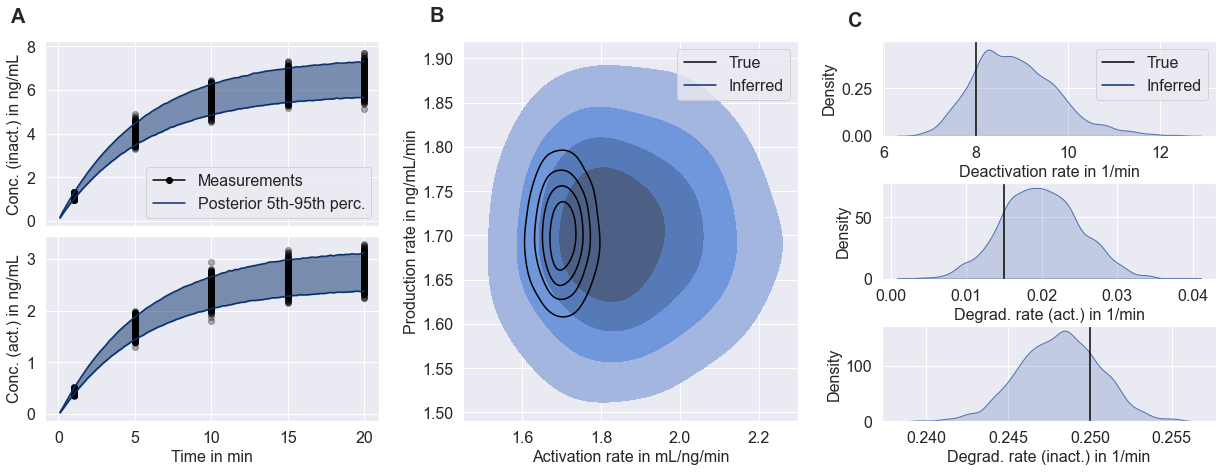

In [53]:
import string

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(21, 7))
outer = gridspec.GridSpec(1, 3, wspace=0.25)

# Create time series axes
inner = gridspec.GridSpecFromSubplotSpec(
    2, 1, subplot_spec=outer[0], hspace=0.05)
ax1 = plt.Subplot(fig, inner[0])
ax2 = plt.Subplot(fig, inner[1])
ax1.sharex(ax2)
time_series_axes = [ax1, ax2]

# Create axis for IIV parameters
ax3 = plt.Subplot(fig, outer[1])

# Create axes for pooled parameters
inner = gridspec.GridSpecFromSubplotSpec(
    3, 1, subplot_spec=outer[2], hspace=0.5)
ax4 = plt.Subplot(fig, inner[0])
ax5 = plt.Subplot(fig, inner[1])
ax6 = plt.Subplot(fig, inner[2])
param_axes = [ax3, ax4, ax5, ax6]

# Add axes to figure
for ax in (time_series_axes + param_axes):
    fig.add_subplot(ax)

# Define population model (central parametrisation)
population_model = chi.ComposedPopulationModel([
    chi.GaussianModel(dim_names=['Activation rate']),
    chi.PooledModel(n_dim=3, dim_names=[
        'Deactivation rate', 'Deg. rate (act.)', 'Deg. rate (inact.)']),
    chi.GaussianModel(dim_names=['Production rate'])])

# Plot population filter inference results (parameter space)
seed = np.random.default_rng(3)
n_samples = 5000
parameters =  posterior_samples.sel(draw=slice(warmup, n_iterations))
parameters = np.vstack([
    parameters['Mean myokit.activation_rate'].values.flatten(),
    parameters['Std. myokit.activation_rate'].values.flatten(),
    parameters['Pooled myokit.deactivation_rate'].values.flatten(),
    parameters[
        'Pooled myokit.degradation_rate_active_receptor'].values.flatten(),
    parameters[
        'Pooled myokit.degradation_rate_inactive_receptor'].values.flatten(),
    parameters['Mean myokit.production_rate'].values.flatten(),
    parameters['Std. myokit.production_rate'].values.flatten()]).T
parameters = parameters[
    np.random.choice(np.arange(len(parameters)), size=n_samples, replace=True)]
samples = np.empty(shape=(n_samples, 5))
for ids, params in enumerate(parameters):
    samples[ids, :] = population_model.sample(params, seed=seed)[0]
sns.kdeplot(
    x=samples[:, 0], y=samples[:, 4], fill=True, bw_adjust=1.5,
    levels=[0.2, 0.4, 0.6, 0.8, 1], ax=param_axes[0])
sns.kdeplot(
    x=samples[:, 1], fill=True, ax=param_axes[1])
sns.kdeplot(
    x=samples[:, 2], fill=True, ax=param_axes[2])
sns.kdeplot(
    x=samples[:, 3], fill=True, ax=param_axes[3])

# Plot population filter inference results (measurement space)
times = np.linspace(0.1, 20, 100)
n_times = len(times)
predictive_model = chi.PredictiveModel(mechanistic_model, error_models)
simulated_measurements = np.empty(shape=(n_samples, 2, n_times))
parameters = np.empty(shape=(n_samples, 7))
parameters[:, :5] = samples
parameters[:, 5] = population_parameters[-2]
parameters[:, 6] = population_parameters[-1]
for ids, sample in enumerate(parameters):
    simulated_measurements[ids, :] = predictive_model.sample(
        parameters=sample, times=times, seed=seed, return_df=False)[..., 0]
fifth_percentile = np.percentile(simulated_measurements, q=5, axis=0)
ninetyfifth_percentile = np.percentile(simulated_measurements, q=95, axis=0)
time_series_axes[0].plot(
    times, fifth_percentile[1], color=plt.get_cmap('Blues_r')(0))
time_series_axes[0].plot(
    times, ninetyfifth_percentile[1], color=plt.get_cmap('Blues_r')(0))
time_series_axes[0].fill_between(
    times, fifth_percentile[1], ninetyfifth_percentile[1],
    color=plt.get_cmap('Blues_r')(1), alpha=0.5)
time_series_axes[1].plot(
    times, fifth_percentile[0], color=plt.get_cmap('Blues_r')(0))
time_series_axes[1].plot(
    times, ninetyfifth_percentile[0], color=plt.get_cmap('Blues_r')(0))
time_series_axes[1].fill_between(
    times, fifth_percentile[0], ninetyfifth_percentile[0],
    color=plt.get_cmap('Blues_r')(0), alpha=0.5)

# Plot data-generating distribution as reference to parameter space
samples = population_model.sample(
    population_parameters[:-2], n_samples, seed)
sns.kdeplot(
    x=samples[:, 0], y=samples[:, 4], fill=False, bw_adjust=1.5, color='black',
    levels=[0.2, 0.4, 0.6, 0.8, 1], ax=param_axes[0])
param_axes[1].axvline(x=population_parameters[2], color='black')
param_axes[2].axvline(x=population_parameters[3], color='black')
param_axes[3].axvline(x=population_parameters[4], color='black')

# Plot measurement used for the inference as reference
times = np.array([1, 5, 10, 15, 20])
for idm, meas in enumerate(measurements):
    time_series_axes[1].scatter(
        times, meas[0], color='black', marker='o', alpha=0.3)
    time_series_axes[0].scatter(
        times, meas[1], color='black', marker='o', alpha=0.3)

# Label axes
fontsize = 16
time_series_axes[1].set_xlabel('Time in min', fontsize=fontsize)
time_series_axes[0].set_ylabel('Conc. (inact.) in ng/mL', fontsize=fontsize)
time_series_axes[1].set_ylabel('Conc. (act.) in ng/mL', fontsize=fontsize)
time_series_axes[0].tick_params(labelsize=fontsize)
# time_series_axes[0].set_xticks([])
time_series_axes[1].tick_params(labelsize=fontsize)
time_series_axes[0].plot(
    [10, 10], [100, 101], color='black', linestyle='solid', marker='o',
    label='Measurements')
time_series_axes[0].plot(
    [10, 10], [100, 101], color=plt.get_cmap('Blues_r')(0),
    linestyle='solid', label='Posterior 5th-95th perc.')
time_series_axes[0].set_ylim([-0.25, 8.25])
param_axes[0].plot(
    [10, 10], [100, 101], color='black', label='True')
param_axes[0].plot(
    [10, 10], [100, 101], color=plt.get_cmap('Blues_r')(0),label='Inferred')
param_axes[1].plot(
    [10, 10], [100, 101], color='black', label='True')
param_axes[1].plot(
    [10, 10], [100, 101], color=plt.get_cmap('Blues_r')(0),label='Inferred')
param_axes[0].set_xlim([1.45, 2.3])
param_axes[0].set_ylim([1.49, 1.92])
param_axes[1].set_ylim([0, 0.499])
param_axes[0].set_xlabel('Activation rate in mL/ng/min', fontsize=fontsize)
param_axes[0].set_ylabel('Production rate in ng/mL/min', fontsize=fontsize)
param_axes[0].tick_params(labelsize=fontsize)
param_axes[1].set_xlabel('Deactivation rate in 1/min', fontsize=fontsize)
param_axes[1].set_ylabel('Density', fontsize=fontsize)
param_axes[1].tick_params(labelsize=fontsize)
param_axes[2].set_xlabel('Degrad. rate (act.) in 1/min', fontsize=fontsize)
param_axes[2].set_ylabel('Density', fontsize=fontsize)
param_axes[2].tick_params(labelsize=fontsize)
param_axes[3].set_xlabel('Degrad. rate (inact.) in 1/min', fontsize=fontsize)
param_axes[3].set_ylabel('Density', fontsize=fontsize)
param_axes[3].tick_params(labelsize=fontsize)
time_series_axes[0].legend(fontsize=fontsize)
param_axes[0].legend(fontsize=fontsize)
param_axes[1].legend(fontsize=fontsize)

# Label subplot groups
ax1.text(
    -0.1, 1.1, string.ascii_uppercase[0], transform=ax1.transAxes, size=20,
    weight='bold')
ax3.text(
    -0.1, 1.05, string.ascii_uppercase[1], transform=ax3.transAxes, size=20,
    weight='bold')
ax4.text(
    -0.1, 1.15, string.ascii_uppercase[2], transform=ax4.transAxes, size=20,
    weight='bold')
plt.show()

Uncertainty about pooled parameters leads to uncertainty about parameters that
display IIV. Together this leads to an overestimation of IIV, consistent with
the prior knowledge. This is in contrast to NMLE inference, where the inference
framework tends to underestimate IIV when uncertainty about bottom-level
parameters is large.